In [2]:
import pandas as pd
import numpy as np
import torch
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score



In [3]:
# Check device 
# Get the GPU device name if available.
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('GPU(s) available: {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
torch.cuda.empty_cache()
    
# Set the seed value all over the place to make this reproducible.
seed_val = 41

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

GPU(s) available: 1
We will use the GPU: NVIDIA GeForce GTX 1650


In [4]:
df=pd.read_csv("data/Dataset_unsupervised.csv")
df.describe()

,Camera
count,2976.000000
mean,0.500000
std,0.500084
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


**Get to Know the Data**

In [5]:
df.groupby('Camera').describe()

Command                                                               
         count unique                                                top freq
Camera                                                                       
0         1488   1061  Return to the launch point via the most effici...   32
1         1488   1009        Fly over the area and assess the situation.   11

<Axes: xlabel='Camera', ylabel='count'>

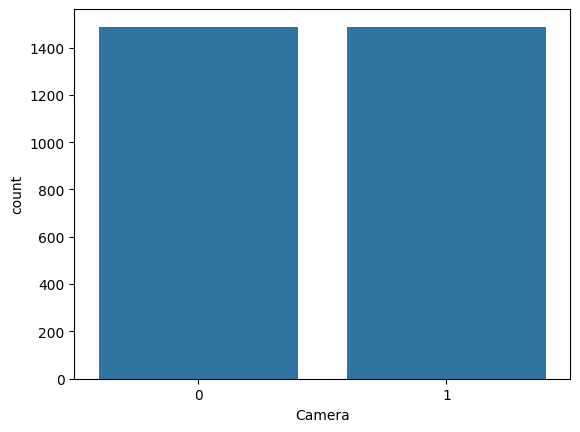

In [6]:
sns.countplot(x=df['Camera'])

[nltk_data] Downloading package stopwords to /home/tarun/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


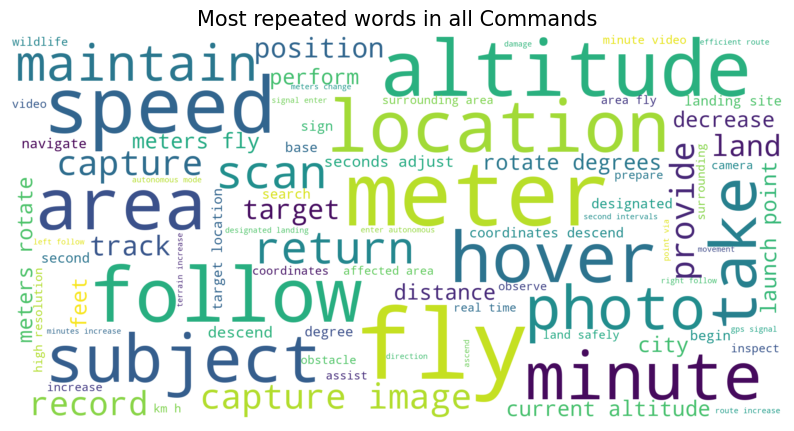

In [7]:
# Wordcloud of text

# Get stopwords
# Define nltk stopwords in english
nltk.download('stopwords')
stop_words = stopwords.words('english')
# Get a string of all the texts available
data_text = ",".join(txt.lower() for txt in df.Command)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, 
                      max_words=100, 
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(data_text)

# Display the generated image:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in all Commands',fontsize=15)
plt.show()

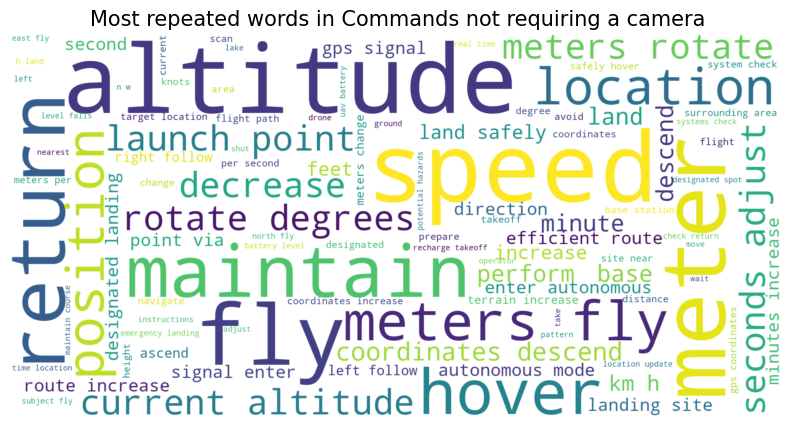

In [11]:
df_nocam = df[df['Camera']==0]
data_text_nocam = ",".join(txt.lower() for txt in df_nocam.Command)

# Create and generate a word cloud image:
wordcloud_nocam = WordCloud(max_font_size=50, 
                      max_words=100, 
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(data_text_nocam)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nocam, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in Commands not requiring a camera',fontsize=15)
plt.show()

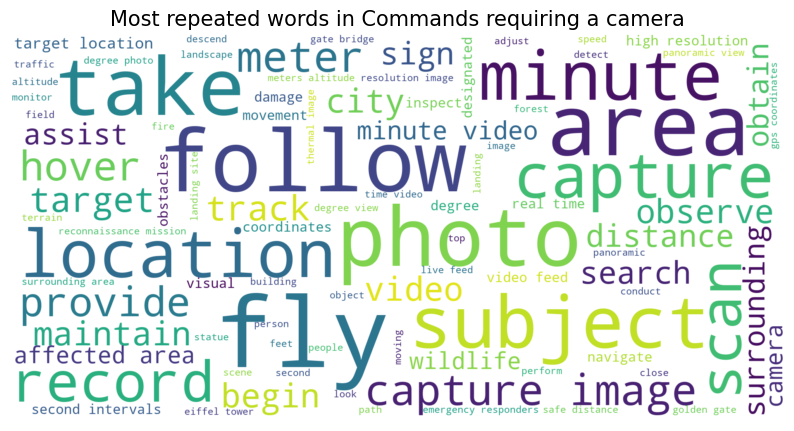

In [12]:
df_cam = df[df['Camera']==1]
data_text_cam = ",".join(txt.lower() for txt in df_cam.Command)

# Create and generate a word cloud image:
wordcloud_cam = WordCloud(max_font_size=50, 
                      max_words=100, 
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(data_text_cam)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud_cam, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in Commands requiring a camera',fontsize=15)
plt.show()

**Downsampling data**

In [10]:
df_cam_downsampled = df_cam.sample(df_nocam.shape[0])
df = pd.concat([df_cam_downsampled, df_nocam])
df.groupby('Camera').describe()

Command                                                               
         count unique                                                top freq
Camera                                                                       
0         1488   1061  Return to the launch point via the most effici...   32
1         1488   1009        Fly over the area and assess the situation.   11

In [50]:
# Split test and train data using 25% of the dataset for validation purposes
x_train, x_test, y_train, y_test = train_test_split(df['Command'], df['Camera'], test_size=0.25, shuffle=True, random_state=41)

**Logistic Regression**

In [53]:
# Create a Pipeline with the TfidfVectorizer and LogisticRegression model
LR_pipeline = Pipeline(steps = [('tf', TfidfVectorizer()), 
                                ('lgrg', LogisticRegression())]) # initialize TfidfVectorizer and LogisticRegression


# Create Parameter Grid
pgrid_lgrg = {
 'tf__max_features' : [1000, 2000, 3000],
 'tf__ngram_range' : [(1,1),(1,2)],
 'tf__use_idf' : [True, False],
 'lgrg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
 'lgrg__class_weight' : ['balanced', None]
}

# Apply GridSearch to Pipeline to find the best parameters
gs_lgrg = GridSearchCV(LR_pipeline, pgrid_lgrg, cv=2, n_jobs=-1, verbose=2)

In [54]:
gs_lgrg.fit(x_train, y_train) # Train LR model

Fitting 2 folds for each of 96 candidates, totalling 192 fits
[CV] END lgrg__class_weight=balanced, lgrg__penalty=l1, tf__max_features=1000, tf__ngram_range=(1, 1), tf__use_idf=False; total time=   0.0s
[CV] END lgrg__class_weight=balanced, lgrg__penalty=l1, tf__max_features=1000, tf__ngram_range=(1, 1), tf__use_idf=True; total time=   0.0s
[CV] END lgrg__class_weight=balanced, lgrg__penalty=l1, tf__max_features=1000, tf__ngram_range=(1, 1), tf__use_idf=True; total time=   0.0s
[CV] END lgrg__class_weight=balanced, lgrg__penalty=l1, tf__max_features=2000, tf__ngram_range=(1, 2), tf__use_idf=True; total time=   0.0s
[CV] END lgrg__class_weight=balanced, lgrg__penalty=l1, tf__max_features=2000, tf__ngram_range=(1, 1), tf__use_idf=True; total time=   0.0s[CV] END lgrg__class_weight=balanced, lgrg__penalty=l1, tf__max_features=1000, tf__ngram_range=(1, 1), tf__use_idf=False; total time=   0.0s

[CV] END lgrg__class_weight=balanced, lgrg__penalty=l1, tf__max_features=2000, tf__ngram_range=(

/home/tarun/btp/Python/Multimodal_AI_In_Drone/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
144 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tarun/btp/Python/Multimodal_AI_In_Drone/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tarun/btp/Python/Multimodal_AI_In_Drone/venv/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/tarun/btp/Python/Multimodal_AI_In_Drone/ve

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lgrg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lgrg__class_weight': ['balanced', None],
                         'lgrg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'tf__max_features': [1000, 2000, 3000],
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__use_idf': [True, False]},
             verbose=2)

In [55]:
gs_lgrg.best_params_

{'lgrg__class_weight': 'balanced',
 'lgrg__penalty': 'l2',
 'tf__max_features': 2000,
 'tf__ngram_range': (1, 2),
 'tf__use_idf': True}

In [56]:
print('Score of train set', gs_lgrg.score(x_train, y_train))
print('Score of test set',gs_lgrg.score(x_test, y_test))

Score of train set 0.9758064516129032
Score of test set 0.9758064516129032


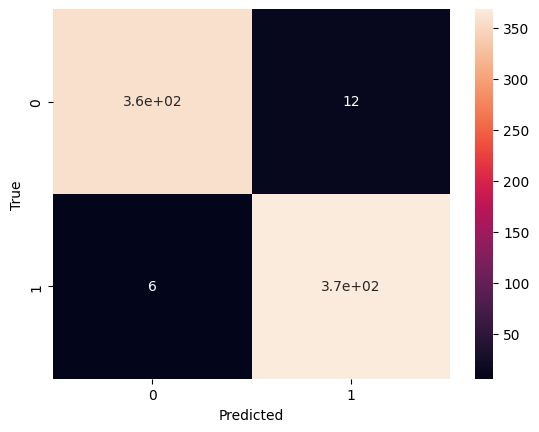

In [57]:
LR_pred = gs_lgrg.predict(x_test) # Predict on validation data

data = {'true_y': y_test,
       'predicted_y': LR_pred}
df_pred = pd.DataFrame(data, columns=['true_y','predicted_y'])
confusion_matrix = pd.crosstab(df_pred['true_y'], df_pred['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [60]:
print('Accuracy of LR model', accuracy_score(y_test, LR_pred))

Accuracy of LR model 0.9758064516129032


In [62]:
target_names = ['true_y', 'predicted_y']
print(classification_report(y_test, LR_pred, target_names=target_names))

              precision    recall  f1-score   support

      true_y       0.98      0.97      0.98       370
 predicted_y       0.97      0.98      0.98       374

    accuracy                           0.98       744
   macro avg       0.98      0.98      0.98       744
weighted avg       0.98      0.98      0.98       744



In [75]:
int(round(gs_lgrg.predict(["Follow the drone please"])[0]))

1

In [66]:
import joblib

# Save the fitted GridSearchCV model
joblib.dump(gs_lgrg, 'log_reg_model.pkl')

['log_reg_model.pkl']

In [68]:
loaded_model = joblib.load('log_reg_model.pkl')

# You can now use the loaded model to make predictions
predictions = loaded_model.predict(["fly with my friend wearing the red shirt and black pant"])

In [69]:
gs_lgrg.predict

array([1])